In [1]:
from mylib.statistic_test import *
from mazepy.datastruc.neuact import SpikeTrain, TuningCurve, NeuralTrajectory
from mazepy.datastruc.variables import VariableBin
from mylib.calcium.dsp_ms import classify_lap
from mazepy.basic._time_sync import _coordinate_recording_time

from umap.umap_ import UMAP
from sklearn.decomposition import PCA
from sklearn.svm import SVC
from sklearn.cluster import DBSCAN
from sklearn.cluster import KMeans

code_id = "Reforming Neural Trajectory Analysis"
loc = join(figpath, "Dsp", code_id)
mkdir(loc)

dir_name = join(figpath, "Dsp", "0850 - Lisa Paper Revisits")

        E:\Data\FinalResults\Dsp\Reforming Neural Trajectory Analysis is already existed!


# If not necessary, do not run the next one block
as its running cost a lot of time and its output is important to the measurement of
DBSCAN efficiency.

Mouse 10212:
    1. Read All Data.
100%|██████████| 7/7 [00:09<00:00,  1.29s/it] 
    2. Mapping Neural Activity.
397 397
    3. DBSCAN-SVM Manifold Classification.
C:\Users\12454\AppData\Local\Temp\ipykernel_24512\3701036970.py:249: RuntimeWarning: divide by zero encountered in divide
  norm_dists = dists / radii[old_traj]
       DBSCAN Cluster n: [0.90481255 0.0153328  0.01373748 0.01320571 0.01276256]
    4. Map Type on the Final Maze Segment

Mouse 10224:
    1. Read All Data.
100%|██████████| 7/7 [00:18<00:00,  2.71s/it]
    2. Mapping Neural Activity.
537 537
    3. DBSCAN-SVM Manifold Classification.
C:\Users\12454\AppData\Local\Temp\ipykernel_24512\3701036970.py:249: RuntimeWarning: divide by zero encountered in divide
  norm_dists = dists / radii[old_traj]
       DBSCAN Cluster n: [0.93514312 0.01760563 0.01294866 0.01005225 0.00562244]
    4. Map Type on the Final Maze Segment

Mouse 10227:
    1. Read All Data.
100%|██████████| 7/7 [00:30<00:00,  4.41s/it]
    2. Mapping Neural Activity.
292 292
    3. DBSCAN-SVM Manifold Classification.
C:\Users\12454\AppData\Local\Temp\ipykernel_24512\3701036970.py:249: RuntimeWarning: divide by zero encountered in divide
  norm_dists = dists / radii[old_traj]
       DBSCAN Cluster n: [0.86962887 0.02232633 0.01705585 0.01610424 0.01573823]
    4. Map Type on the Final Maze Segment

Mouse 10232:
    1. Read All Data.
100%|██████████| 7/7 [00:19<00:00,  2.72s/it]
    2. Mapping Neural Activity.
638 638
    3. DBSCAN-SVM Manifold Classification.
C:\Users\12454\AppData\Local\Temp\ipykernel_24512\3701036970.py:249: RuntimeWarning: divide by zero encountered in divide
  norm_dists = dists / radii[old_traj]
       DBSCAN Cluster n: [0.88665697 0.00952739 0.00746234 0.00736847 0.00657061]
    4. Map Type on the Final Maze Segment

In [2]:
def get_neural_traj(trace: dict, is_shuffle=False):    
    beg_time, end_time = trace['lap beg time'], trace['lap end time']
    beg_idx, end_idx = LapSplit(trace, trace['paradigm'])
    routes = classify_lap(spike_nodes_transform(trace['correct_nodes'], 12), beg_idx)
    
    neural_trajs = []
    pos_trajs = []
    time_trajs = []
    cumlen_trajs = []
    route_trajs = []
    lap_trajs = []
    speed_trajs = []
    perfect_trajs = []
    
    behav_trajs = []
    behav_lap_trajs = []
    behav_route_trajs = []
    behav_to_ms_trajs = []
    
    subtract_degree = np.array([0, np.pi, np.pi, np.pi/2, np.pi, np.pi/2*3, np.pi], np.float64)
    
    n_frames = 0
    for i in tqdm(range(beg_idx.shape[0])):
        
        behav_param = np.zeros((7, end_idx[i]-beg_idx[i]), np.float64) # allocentric parameters: Xa, Ya, Theta_a + Egocentric parameters: Xe, Ye, Theta_e
        behav_diffs = np.zeros((5, end_idx[i]-beg_idx[i]), np.float64) # Differential Items:     dx, dy, v (speed), omega (angular speed), dt
        
        spike_idx = np.where(
            (trace['ms_time'] >= beg_time[i]) & (trace['ms_time'] <= end_time[i]) &
            (np.isnan(trace['spike_nodes_original']) == False)
        )[0]
        
        behav_param[0, :] = trace['correct_pos'][beg_idx[i]:end_idx[i], 0] / 10 # Allocentric X
        behav_param[1, :] = trace['correct_pos'][beg_idx[i]:end_idx[i], 1] / 10 # Allocentric Y
        behav_param[3, :] = behav_param[0, :] - behav_param[0, 0]  # Egocentric X
        behav_param[4, :] = behav_param[1, :] - behav_param[1, 0]  # Egocentric Y 
        
        dx = np.ediff1d(trace['correct_pos'][beg_idx[i]:end_idx[i], 0])/10
        dy = np.ediff1d(trace['correct_pos'][beg_idx[i]:end_idx[i], 1])/10
        dis = np.sqrt(dx**2+dy**2)
        cumdis = np.concatenate([[0], np.cumsum(dis)])
        dt = np.ediff1d(trace['correct_time'][beg_idx[i]:end_idx[i]]) / 1000
        behav_param[6, :] = t = (trace['correct_time'][beg_idx[i]:end_idx[i]] - trace['correct_time'][beg_idx[i]]) / 1000
        v = dis / dt
        
        behav_param[2, 1:] = np.arctan2(dy, dx) # Allocentric Head Direction
        behav_param[2, 0] = subtract_degree[routes[i]]
        behav_param[5, :] = behav_param[2, :] - behav_param[2, 0] # Egocentric Head Direction
        omega = np.ediff1d(behav_param[2, :]) / dt
        
        behav_diffs[0, 1:] = dx # Displacement in X
        behav_diffs[1, 1:] = dy # Displacement in Y
        behav_diffs[2, 1:] = v # Speed
        behav_diffs[3, 1:] = omega # Angular Speed
        behav_diffs[4, 1:] = dt # Time Interval
        behav_trajs.append(np.vstack([behav_param, behav_diffs]))
        behav_lap_trajs.append(np.repeat(i, behav_param.shape[1]).astype(np.int64))
        behav_route_trajs.append(np.repeat(routes[i], behav_param.shape[1]).astype(np.int64))
        
        spike_nodes = trace['spike_nodes_original'][spike_idx].astype(np.int64)-1
        Spikes = trace['Spikes_original'][:, spike_idx]
        
        spike_train = SpikeTrain(
            activity=Spikes,
            time=trace['ms_time'][spike_idx],
            variable=VariableBin(spike_nodes),
        )
        
        neural_traj = spike_train.calc_neural_trajectory(500, 100)
        neural_traj_vec = neural_traj.to_array()
        pos_traj = neural_traj.variable.to_array()
        time_traj = neural_traj.time
        idx = _coordinate_recording_time(time_traj.astype(np.float64), t.astype(np.float64))
        behav_to_ms_trajs.append(idx + n_frames)
        n_frames += behav_param.shape[1]
        
        neural_trajs.append(neural_traj_vec)
        pos_trajs.append(pos_traj)
        time_trajs.append(time_traj - trace['ms_time'][spike_idx[0]])
        speed_trajs.append(behav_diffs[2, idx])
        cumlen_trajs.append(cumdis[idx])
        
        route_trajs.append(np.repeat(routes[i], neural_traj_vec.shape[1]).astype(np.int64))
        lap_trajs.append(np.repeat(i, neural_traj_vec.shape[1]).astype(np.int64))
        perfect_trajs.append(np.repeat(int(trace['is_perfect'][i]), neural_traj_vec.shape[1]))

    return (
        np.concatenate(neural_trajs, axis=1), 
        np.concatenate(pos_trajs), 
        np.concatenate(time_trajs),
        np.concatenate(route_trajs), 
        np.concatenate(lap_trajs), 
        np.concatenate(speed_trajs),
        np.concatenate(cumlen_trajs),
        np.concatenate(perfect_trajs),
        np.concatenate(behav_trajs, axis=1),
        np.concatenate(behav_lap_trajs),
        np.concatenate(behav_route_trajs),
        np.concatenate(behav_to_ms_trajs).astype(np.int64)
    )

@jit(nopython=True)
def _calc_shortest_idx(src_neural_traj, targ_neural_traj):
    """
    Calculate the most similar population vector (PV) in the target
    trajectory for each PV in the source trajectory.
    
    Parameters
    ----------
    src_neural_traj : NDarray[float], (n_neuron, T1)
        The source neural trajectory.
    targ_neural_traj : NDarray[float], (n_neuron, T2)
    
    Returns
    -------
    idx : NDarray[int], (T1,)
        The index of the most similar PV in the target trajectory for each PV
        in the source trajectory.
        values of idx are in the range [0, T2-1].
    val : NDarray[float], (T1,)
        The correlation coefficient between the source and target PVs.
    """
    idx = np.zeros(src_neural_traj.shape[1], dtype=np.int64)
    val = np.zeros(src_neural_traj.shape[1])
    for i in range(src_neural_traj.shape[1]):
        corrs = np.zeros(targ_neural_traj.shape[1])
        for j in range(targ_neural_traj.shape[1]):
            corrs[j] = np.corrcoef(src_neural_traj[:, i], targ_neural_traj[:, j])[0, 1]
        
        corrs[np.where(np.isnan(corrs))[0]] = -1
        idx[i] = np.argmax(corrs)
        val[i] = np.max(corrs)
    return idx, val

def mapping_neural_activity(trace):
    """
    Decode position from neural trajectory.
    
    Parameters
    ----------
    trace : dict
        Data object
    route: int
        The route to be decoded
    targ_route: int
        Target Route, by default 0
        
    Returns
    -------
    The corresponding positions on route 1.
    (Route 1 shape, ), (Route n shape, ), (Route n shape, ), (
        (n_neuron, Route n shape), 
        (Route n shape, ), 
        (Route n shape, ), 
        (Route n shape, ), 
        (Route n shape, ), 
        (Route n shape, ),
        (Route n shape, )
    )
    
    Notes
    -----
    There's a highly similar function in 
    'Fig0855 - Mapping Initialization Phase.ipynb.ipynb'
    which only differs in the parameters.
    """

    (
        neural_traj,
        pos_traj,
        time_traj,
        route_traj,
        lap_traj,
        speed_traj,
        len_traj,
        perfect_traj,
        behav_traj,
        behav_lap_traj,
        behav_route_traj,
        behav_to_ms_traj
    ) = get_neural_traj(trace)
    
    decoded_idx_traj = np.zeros_like(pos_traj, np.int64)
    
    targ_idx = np.where(route_traj == 0)[0]
    targ_neural_traj = neural_traj[:, targ_idx]
    targ_pos_traj = pos_traj[targ_idx]
    targ_speed_traj = speed_traj[targ_idx]
    decoded_idx_traj[targ_idx] = targ_idx
    decoded_corr_traj = np.zeros_like(pos_traj)
    decoded_corr_traj[targ_idx] = 1
    
    for route in tqdm(range(1, 7)):
        
        src_idx = np.where(route_traj == route)[0]
        src_neural_traj = neural_traj[:, src_idx]
    
        src_to_targ_idx, corr_val = _calc_shortest_idx(src_neural_traj, targ_neural_traj)
        decoded_idx_traj[src_idx] = targ_idx[src_to_targ_idx]
        decoded_corr_traj[src_idx] = corr_val
        
    beg_time, end_time = trace['lap beg time'], trace['lap end time']
    
    # Get Loss Traj
    D = GetDMatrices(1, 48)
    loss_traj = np.array([D[pos_traj[i], pos_traj[decoded_idx_traj[i]]] for i in range(pos_traj.shape[0])], dtype=np.float64)
    smoothed_loss_traj = np.zeros_like(loss_traj)
    beg = np.concatenate([[0], np.where(np.ediff1d(lap_traj) != 0)[0]+1])
    end = np.concatenate([np.where(np.ediff1d(lap_traj) != 0)[0]+1, [decoded_idx_traj.shape[0]]])
    retriv_state_traj = np.zeros_like(loss_traj) # 0 - not retrieved, 1 - retrieved, 2 - missed after retrieval
    
    for i in range(beg.shape[0]):
        smoothed_loss_traj[beg[i]:end[i]] = np.convolve(loss_traj[beg[i]:end[i]], np.ones(10)/10, 'same')
        
        if route_traj[beg[i]] == 0:
            retriv_state_traj[beg[i]:end[i]] = 1
            continue
        
        _converge_idx = np.where(
            (smoothed_loss_traj[beg[i]:end[i]] <= 10) &
            (decoded_corr_traj[beg[i]:end[i]] >= 0.0)
        )[0]
        
        if _converge_idx.shape[0] < 1:
            continue
            
        retriv_state_traj[beg[i]:beg[i] + _converge_idx[0]] = 0
        retriv_state_traj[beg[i] + _converge_idx[0]:end[i]] = 2
        retriv_state_traj[beg[i] + _converge_idx] = 1
        
    return (
        neural_traj,
        pos_traj,
        time_traj,
        route_traj,
        lap_traj,
        speed_traj,
        len_traj,
        perfect_traj,
        
        behav_traj,
        behav_lap_traj,
        behav_route_traj,
        behav_to_ms_traj,
        
        decoded_idx_traj,
        decoded_corr_traj,
        loss_traj,
        smoothed_loss_traj,
        retriv_state_traj
    )

def compute_centroids(
    reduced_data: np.ndarray,
    route_traj: np.ndarray,
    pos_traj: np.ndarray
):
    idx = np.where(route_traj==0)[0]

    old_traj = spike_nodes_transform(pos_traj[idx]+1, 12)-1
    radii = np.zeros(144)
    centroids = np.zeros((144, 3))
    for i in CP_DSP[0]-1:
        subids = np.where(old_traj == i)[0]
        centroids[i, :] = np.mean(reduced_data[idx[subids], :], axis=0)[:3]
        res = reduced_data[idx[subids], :][:, :3] - centroids[i, :]
        radii[i] = np.percentile(
            np.sqrt(np.sum(res**2, axis=1)), 90
        )
    return centroids, radii
        
def find_min_normalized_distance(points, pos_traj, centroids, radii):
    """
    points   : shape (N, 3)
    centroids: shape (C, 3)
    radii    : shape (C,)  (the 95% range for each centroid)
    
    Returns
    -------
    min_norm_dist : shape (N,)  (the min normalized distance for each point)
    best_centroid : shape (N,)  (index of centroid with min normalized distance)
    """
    old_traj = spike_nodes_transform(pos_traj+1, 12)-1
    # Compute pairwise distance (N, C)
    # diffs[i, j] = points[i] - centroids[j]
    diffs = points - centroids[old_traj, :]  # shape (N, 3)
    sq_dists = np.sum(diffs**2, axis=1)                             # shape (N, )
    dists = np.sqrt(sq_dists)                                       # shape (N, )
    
    # Divide each distance by that centroid's radius
    # radii is (C,), so we broadcast to (N, C)
    norm_dists = dists / radii[old_traj]
    return norm_dists

def umap_dim_reduction(
    neural_traj: np.ndarray,
    route_traj: np.ndarray,
    pos_traj: np.ndarray
):
    pca = PCA(n_components=30, random_state=42)
    denoised_data = pca.fit_transform(neural_traj.T)
    model = UMAP(n_components=3)
    reduced_data = model.fit_transform(denoised_data)
    
    # Use DBSCAN to further denoise
    dbscan = DBSCAN(eps=1, min_samples=50)
    res = dbscan.fit_predict(reduced_data[:, :3])
    idx = np.where(res != -1)[0]
    
    neural_traj_dn = neural_traj[:, idx]
    route_traj_dn = route_traj[idx]
    pos_traj_dn = pos_traj[idx]
    reduced_data_dn = reduced_data[idx, :]
    
    centroid, raddi = compute_centroids(
        reduced_data=reduced_data_dn,
        route_traj=route_traj_dn,
        pos_traj=pos_traj_dn
    )
    
    norm_distance_traj = find_min_normalized_distance(reduced_data[:, :3], pos_traj, centroid, raddi)
    manifold_traj = np.where(norm_distance_traj <= 1, 0, -1)
    
    dbscan = DBSCAN(eps=0.4, min_samples=50)
    idx = np.where(manifold_traj == -1)[0]
    res = dbscan.fit_predict(reduced_data[idx, :3])
    
    uniq_labels = np.unique(res)[1:]
    lab_max = np.max(uniq_labels)
    n_labels = np.histogram(res, bins=lab_max+1, range=(-0.5, lab_max+0.5), density=True)[0]
    arg_sort = np.argsort(n_labels)
    uniq_labels = uniq_labels[arg_sort][::-1]
    
    manifold_traj[idx[res == uniq_labels[0]]] = 1
    
    print(f"       DBSCAN Cluster n: {n_labels[arg_sort][::-1][:5] if uniq_labels.shape[0] > 5 else n_labels[arg_sort][::-1]}")
    
    # SVM to classify manifold
    svm = SVC(kernel="rbf", random_state=42)
    svm.fit(reduced_data[manifold_traj >= 0, :3], manifold_traj[manifold_traj >= 0])
    manifold_traj = np.asarray(svm.predict(reduced_data[:, :3])).astype(np.int64)
    svm_distance_traj = np.asarray(svm.decision_function(reduced_data[:, :3])).astype(np.float64)
    
    return norm_distance_traj, reduced_data, manifold_traj, svm_distance_traj, centroid, raddi
    
def fit_kmeans(X, R: int, kmeans_init=None, is_return_model: bool = False):
    """
    Cluster Maps with KMeans model.
    
    Parameters
    ----------
    X : np.ndarray
        The entire map of this cell within this session.
        shape: (I x J x K) tensor of normalized firing rates
        
        I: Trials
        J: Spatial bins
        K: Neurons
    
    Returns
    -------
    U, V
    
    Notes
    -----
    There's a same function in 
    Fig0850 - Lisa Paper Revisits.ipynb
    """
    X_wrap = np.reshape(X, (X.shape[0], X.shape[1]*X.shape[2]))
    
    if kmeans_init is not None:
        kmean = KMeans(n_clusters=R, init=kmeans_init)
    else:
        kmean = KMeans(n_clusters=R)
        
    kmean.fit(X_wrap)
    
    U = np.zeros((X.shape[0], R))
    for i in range(X.shape[0]):
        U[i, kmean.labels_[i]] = 1
        
    V = kmean.cluster_centers_
    
    if R == 2 and is_return_model == False:
        nclusters = np.sum(U, axis=0)
        if nclusters[0] < nclusters[1]:
            print(f"{nclusters[0]} < {nclusters[1]}")
            U = U[:, [1, 0]]
            V = V[[1, 0], :]
    
    if is_return_model:
        return U, V, kmean
    else:
        return U, V

def concatenate_trajs(mouse: int):
    """
    Concatenate all traces of a mouse
    
    Parameters
    ----------
    mouse : int
        Mouse ID
    """
    
    print(f"Mouse {mouse}:")
    print("    1. Read All Data.")
    traces = []
    for i in tqdm(np.where(f2['MiceID'] == mouse)[0]):
        with open(f2['Trace File'][i], 'rb') as handle:
            traces.append(pickle.load(handle))
    
    is_perfect = np.concatenate([trace['is_perfect'] for trace in traces])
    
    if exists(join(loc, f" {mouse}_presave.pkl")):
        with open(join(loc, f"{mouse}_presave.pkl"), 'rb') as handle:
            res = pickle.load(handle)
        
        neural_traj = res['neural_traj']
        pos_traj = res['pos_traj']
        time_traj = res['time_traj']
        route_traj = res['route_traj']
        lap_traj = res['lap_traj']
        session_traj = res['session_traj']
        speed_traj = res['speed_traj']
        len_traj = res['len_traj']
        perfect_traj = res['perfect_traj']
        decoded_idx_traj = res['decoded_idx_traj']
        decoded_corr_traj = res['decoded_corr_traj']
        loss_traj = res['loss_traj']
        smoothed_loss_traj = res['smoothed_loss_traj']
        retriv_state_traj = res['retriv_state_traj']
        
        behav_traj = res['behav_traj']
        behav_lap_traj = res['behav_lap_traj']
        behav_session_traj = res['behav_session_traj']
        behav_route_traj = res['behav_route_traj']
        behav_to_ms_traj = res['behav_to_ms_traj']
    else:       

        with open(f_CellReg_dsp['cellreg_folder'][np.where(f_CellReg_dsp['MiceID'] == mouse)[0][0]], 'rb') as handle:
            index_map = pickle.load(handle)
    
            if mouse != 10232:
                index_map = index_map[1:, :]
            
            index_map = index_map.astype(np.int64)
        
            cell_map = np.where(index_map > 0, 1, 0)
            idx = np.where(np.sum(cell_map, axis=0) == 7)[0]
        
            index_map = index_map[:, idx]
    
        neural_trajs = []
        pos_trajs = []
        time_trajs = []
        route_trajs = []
        lap_trajs = []
        session_trajs = []
        speed_trajs = []
        len_trajs = []
        perfect_trajs = []
        decoded_idx_trajs = []
        decoded_corr_trajs = []
        loss_trajs = []
        smoothed_loss_trajs = []
        retriv_state_trajs = []
        
        behav_trajs = []
        behav_lap_trajs = []
        behav_route_trajs = []
        behav_session_trajs = []    
        behav_to_ms_trajs = []
        
        print("    2. Mapping Neural Activity.")
        n_frames = 0
        for s, trace in enumerate(traces):
            print(f"        Session {s+1}")
            (
                neural_traj,
                pos_traj,
                time_traj,
                route_traj,
                lap_traj,
                speed_traj,
                len_traj,
                perfect_traj,
                
                behav_traj,
                behav_lap_traj,
                behav_route_traj,
                behav_to_ms_traj,
                
                decoded_idx_traj,
                decoded_corr_traj,
                loss_traj,
                smoothed_loss_traj,
                retriv_state_traj
            ) = mapping_neural_activity(trace)
        
            neural_trajs.append(neural_traj[index_map[s, :]-1, :])
            pos_trajs.append(pos_traj)
            time_trajs.append(time_traj)
            route_trajs.append(route_traj)
            lap_trajs.append(lap_traj)
            session_trajs.append(np.repeat(s, neural_traj.shape[1]))
            speed_trajs.append(speed_traj)
            len_trajs.append(len_traj)
            perfect_trajs.append(perfect_traj)
            decoded_idx_trajs.append(decoded_idx_traj)    
            decoded_corr_trajs.append(decoded_corr_traj)
            loss_trajs.append(loss_traj)
            smoothed_loss_trajs.append(smoothed_loss_traj)
            retriv_state_trajs.append(retriv_state_traj)
            
            behav_trajs.append(behav_traj)
            behav_lap_trajs.append(behav_lap_traj)
            behav_route_trajs.append(behav_route_traj)
            behav_session_trajs.append(np.repeat(s, behav_route_traj.shape[0]))
            behav_to_ms_trajs.append(behav_to_ms_traj + n_frames)
            n_frames += behav_traj.shape[1]
        
        neural_traj = np.concatenate(neural_trajs, axis = 1)
        pos_traj = np.concatenate(pos_trajs)
        time_traj = np.concatenate(time_trajs)
        route_traj = np.concatenate(route_trajs)
        lap_traj = np.concatenate(lap_trajs)
        session_traj = np.concatenate(session_trajs)
        speed_traj = np.concatenate(speed_trajs)
        len_traj = np.concatenate(len_trajs)
        perfect_traj = np.concatenate(perfect_trajs)
        decoded_idx_traj = np.concatenate(decoded_idx_trajs)
        decoded_corr_traj = np.concatenate(decoded_corr_trajs)
        loss_traj = np.concatenate(loss_trajs)
        smoothed_loss_traj = np.concatenate(smoothed_loss_trajs)
        retriv_state_traj = np.concatenate(retriv_state_trajs)
        
        behav_traj = np.concatenate(behav_trajs, axis = 1)
        behav_lap_traj = np.concatenate(behav_lap_trajs)
        behav_route_traj = np.concatenate(behav_route_trajs)
        behav_session_traj = np.concatenate(behav_session_trajs)
        behav_to_ms_traj = np.concatenate(behav_to_ms_trajs)
    
        print(np.where(np.ediff1d(lap_traj) != 0)[0].shape[0]+1, np.where(is_perfect == 1)[0].shape[0])
        #assert np.where(np.ediff1d(lap_traj) != 0)[0].shape[0]+1 == np.where(is_perfect == 1)[0].shape[0]
        
        with open(join(loc, f"{mouse}_presave.pkl"), 'wb') as handle:
            pickle.dump(
                {
                    'neural_traj': neural_traj,
                    'pos_traj': pos_traj,
                    'time_traj': time_traj,
                    'route_traj': route_traj,
                    'lap_traj': lap_traj,
                    'session_traj': session_traj,
                    'speed_traj': speed_traj,
                    'len_traj': len_traj,
                    'perfect_traj': perfect_traj,
                    'decoded_idx_traj': decoded_idx_traj,
                    'decoded_corr_traj': decoded_corr_traj,
                    'loss_traj': loss_traj,
                    'smoothed_loss_traj': smoothed_loss_traj,
                    'retriv_state_traj': retriv_state_traj,
                    
                    'behav_traj': behav_traj,
                    'behav_lap_traj': behav_lap_traj,
                    'behav_route_traj': behav_route_traj,
                    'behav_session_traj': behav_session_traj,
                    'behav_to_ms_traj': behav_to_ms_traj
                }, handle)
    
    #print("    3. DBSCAN-SVM Manifold Classification.")
    #norm_distance_traj, reduced_traj, manifold_traj, svm_distance_traj, centroid, raddi = umap_dim_reduction(neural_traj, route_traj, pos_traj)
    
    print("    4. Map Type on the Final Maze Segment")
    with open(join(dir_name, f"{mouse}.pkl"), "rb") as f:
        X, session_label, route_label, kmeans_init = pickle.load(f)
    
    kmeans_init = np.vstack([
        np.mean(i, axis=0) for i in kmeans_init
    ])
    US, VS = [], []
    for i in range(7):
        U, V = fit_kmeans(X[session_label == i, :, :], 2, kmeans_init=kmeans_init)
        US.append(U)
        VS.append(V)
        
    final_map_type = np.concatenate(US, axis=0)[:, 1]#[is_perfect == 1]
    beg = np.concatenate([[0], np.where(np.ediff1d(lap_traj) != 0)[0]+1])
    end = np.concatenate([np.where(np.ediff1d(lap_traj) != 0)[0], [neural_traj.shape[1]]])
    final_map_traj = np.zeros_like(lap_traj)
    for i in range(len(beg)):
        final_map_traj[beg[i]:end[i]] = final_map_type[i]
    
    with open(join(loc, f"{mouse}.pkl"), 'wb') as handle:
        pickle.dump(
            {
                'neural_traj': neural_traj.astype(np.float64),
                'pos_traj': pos_traj.astype(np.int64),
                'time_traj': time_traj.astype(np.float64),
                'route_traj': route_traj.astype(np.int64),
                'lap_traj': lap_traj.astype(np.int64),
                'session_traj': session_traj.astype(np.int64),
                'speed_traj': speed_traj.astype(np.float64),
                'len_traj': len_traj.astype(np.float64),
                'perfect_traj': perfect_traj.astype(np.int64),
                'decoded_idx_traj': decoded_idx_traj.astype(np.int64),
                'decoded_corr_traj': decoded_corr_traj.astype(np.float64),
                'loss_traj': loss_traj.astype(np.float64),
                'smoothed_loss_traj': smoothed_loss_traj.astype(np.float64),
                'retriv_state_traj': retriv_state_traj.astype(np.int64),
                    
                'behav_traj': behav_traj,
                'behav_lap_traj': behav_lap_traj,
                'behav_route_traj': behav_route_traj,
                'behav_session_traj': behav_session_traj,
                'behav_to_ms_traj': behav_to_ms_traj,
                
                #'norm_distance_traj': norm_distance_traj.astype(np.float64),
                #'reduced_traj': reduced_traj.astype(np.float64),
                #'manifold_traj': manifold_traj.astype(np.int64),
                #'m0_centroids': centroid.astype(np.float64),
                #'m0_raddi': raddi.astype(np.float64),
                #'m1_centroids': np.vstack([
                #    np.mean(reduced_traj[np.where((manifold_traj == 1) & (route_traj == i))[0], :], axis=0) for i in range(7)
                #]),
                #'svm_distance_traj': svm_distance_traj.astype(np.float64),
                'final_map_traj': final_map_traj.astype(np.int64)
            }, handle)
    
#concatenate_trajs(10212)
#concatenate_trajs(10224)
concatenate_trajs(10227)
concatenate_trajs(10232)

Mouse 10227:
    1. Read All Data.


100%|██████████| 7/7 [00:26<00:00,  3.74s/it]


    2. Mapping Neural Activity.
        Session 1


100%|██████████| 6/6 [13:06<00:00, 131.16s/it]


        Session 2


100%|██████████| 6/6 [11:29<00:00, 114.89s/it]


        Session 3


100%|██████████| 6/6 [07:46<00:00, 77.71s/it]


        Session 4


100%|██████████| 6/6 [05:56<00:00, 59.40s/it]


        Session 5


100%|██████████| 6/6 [08:44<00:00, 87.41s/it] 


        Session 6


100%|██████████| 6/6 [07:49<00:00, 78.23s/it] 


        Session 7


100%|██████████| 6/6 [05:49<00:00, 58.28s/it]


619 292
    4. Map Type on the Final Maze Segment


e:\Anaconda\envs\maze\lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(
e:\Anaconda\envs\maze\lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(
e:\Anaconda\envs\maze\lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(
e:\Anaconda\envs\maze\lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning: KMeans is known to have a memory leak on Windows with MKL, 

Mouse 10232:
    1. Read All Data.


100%|██████████| 7/7 [00:20<00:00,  2.94s/it]


    2. Mapping Neural Activity.
        Session 1


100%|██████████| 6/6 [13:54<00:00, 139.15s/it]


        Session 2


100%|██████████| 6/6 [05:11<00:00, 51.85s/it]


        Session 3


100%|██████████| 6/6 [03:53<00:00, 38.98s/it]


        Session 4


100%|██████████| 6/6 [03:53<00:00, 38.91s/it]


        Session 5


100%|██████████| 6/6 [08:21<00:00, 83.53s/it] 


        Session 6


100%|██████████| 6/6 [05:37<00:00, 56.27s/it]


        Session 7


100%|██████████| 6/6 [04:21<00:00, 43.51s/it]


776 638
    4. Map Type on the Final Maze Segment


e:\Anaconda\envs\maze\lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(
e:\Anaconda\envs\maze\lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(
e:\Anaconda\envs\maze\lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(
e:\Anaconda\envs\maze\lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning: KMeans is known to have a memory leak on Windows with MKL, 

# DBSCAN Cluster Point Number
please note that run the above block first; it will return the values of the 5th largest cluster (**DBSCAN Cluster n**)
and I manually copied them to this block in order to visualize that there's only one additional
submanifold in addition to the prior map relevant submanifold.

In [18]:
Data = {
    'MiceID': np.concatenate([np.repeat(mouse, 5) for mouse in [10212, 10224, 10227, 10232]]),
    'Proportion': np.array([
        0.91124208, 0.01856087, 0.01469036, 0.01389866, 0.0138107, # 10212
        0.93541854, 0.01732673, 0.01265752, 0.01063231, 0.00624437, # 10224
        0.90610364, 0.01635566, 0.01613263, 0.01397666, 0.00966471, # 10227
        0.88082154, 0.00996647, 0.00782414, 0.00782414, 0.00675298  # 10232
    ]),
    'Cluster ID': np.concatenate([np.arange(5) for mouse in [10212, 10224, 10227, 10232]]),
}

fig = plt.figure(figsize=(1.6, 3))
ax = Clear_Axes(plt.axes(), close_spines=['top', 'right'], ifxticks=True, ifyticks=True)
sns.stripplot(
    x = 'Cluster ID', 
    y = 'Proportion', 
    data = Data,
    hue = 'MiceID',
    palette=MicePaletteDSP,
    ax = ax,
    s = 5,
    linewidth = 0.3,
    edgecolor = 'k',
    zorder = 1,
    jitter = 0.2,
)
sns.barplot(
    x = 'Cluster ID', 
    y = 'Proportion', 
    data = Data,
    ax = ax,
    capsize = 0.3,
    err_kws={'linewidth': 0.5, 'color': 'k'},
    zorder = 2,
)

ax.set_ylim([-0.01, 1])
ax.set_yticks(np.linspace(0, 1, 6))
plt.savefig(os.path.join(loc, 'DBSCAN Cluster Proportion.png'), dpi = 600)
plt.savefig(os.path.join(loc, 'DBSCAN Cluster Proportion.svg'), dpi = 600)
plt.close()

fig = plt.figure(figsize=(1.6, 3))
ax = Clear_Axes(plt.axes(), close_spines=['top', 'right'], ifxticks=True, ifyticks=True)
sns.stripplot(
    x = 'Cluster ID', 
    y = 'Proportion', 
    data = Data,
    hue = 'MiceID',
    palette=MicePaletteDSP,
    ax = ax,
    s = 5,
    linewidth = 0.3,
    edgecolor = 'k',
    zorder = 1,
    jitter = 0.2,
)
sns.barplot(
    x = Data['Cluster ID'], 
    y = Data['Proportion'], 
    ax = ax,
    capsize = 0.3,
    err_kws={'linewidth': 0.5, 'color': 'k'},
    zorder = 2,
    alpha=0.5
)
ax.semilogy()
ax.set_ylim([0.005, 1])
plt.savefig(os.path.join(loc, 'DBSCAN Cluster Proportion [semilogy].png'), dpi = 600)
plt.savefig(os.path.join(loc, 'DBSCAN Cluster Proportion [semilogy].svg'), dpi = 600)
plt.close()

print_estimator(Data['Proportion'][Data['Cluster ID'] == 0])
print_estimator(Data['Proportion'][Data['Cluster ID'] == 1])
print(ttest_rel(Data['Proportion'][Data['Cluster ID'] == 0], Data['Proportion'][Data['Cluster ID'] == 1]))

  Mean: 0.90839645, STD: 0.019390226902161307, Max: 0.93541854, Min: 0.88082154, Median: 0.90867286, df: 3
  Mean: 0.0155524325, STD: 0.0033183949161482798, Max: 0.01856087, Min: 0.00996647, Median: 0.016841195, df: 3
TtestResult(statistic=91.98482421747153, pvalue=2.8322882381154606e-06, df=3)


# Identify the proportion of the additional manifold
1. it is the manifold before initialization
2. it is the manifold of low speed movement
3. it is the manifold of starting points related

In [ ]:
if exists(join(figdata, f"{code_id} [Retrival State & Manifold Identity].pkl")) == False:
    RSMIData = {
        "MiceID": [],
        "Manifold": [],
        "Retrival State": [],
        "Mean SVM Distance": []
    }
    
    RSMIProbData = {
        "MiceID": [],
        "SVM Distance": [],
        "Prob of Retrieval": []
    }
    for mouse in [10212, 10224, 10227, 10232]:
        with open(join(loc, f"{mouse}.pkl"), "rb") as f:
            res = pickle.load(f)
        
        manifold_traj = res['manifold_traj']
        retriv_state_traj = res['retriv_state_traj']
        route_traj = res['route_traj']
        svm_dist_traj = res['svm_distance_traj']
    
        # Prior Map Manifold, unretrieved
        idx_m0_r0 = np.where((manifold_traj == 0) & (retriv_state_traj == 0) & (route_traj != 0))[0]
        # Initial Manifold, unretrieved
        idx_m1_r0 = np.where((manifold_traj == 1) & (retriv_state_traj == 0) & (route_traj != 0))[0]
        # Prior Map Manifold, retrieved
        idx_m0_r1 = np.where((manifold_traj == 0) & (retriv_state_traj == 1) & (route_traj != 0))[0]
        # Initial Manifold, retrieved
        idx_m1_r1 = np.where((manifold_traj == 1) & (retriv_state_traj == 1) & (route_traj != 0))[0]
        
        # Prior Map Manifold,
        idx_m0 = np.where((manifold_traj == 0) & (route_traj != 0))[0]
        # Initial Manifold,
        idx_m1 = np.where((manifold_traj == 1) & (route_traj != 0))[0]
        
        # Prior Map Manifold, unretrieved
        idx_r0 = np.where(retriv_state_traj == 0)[0]
        # Initial Manifold, unretrieved
        idx_r1 = np.where(retriv_state_traj == 1)[0]
        
        print(mouse)
        print(np.array([
            [idx_m0_r0.shape[0]/idx_m0.shape[0], idx_m1_r0.shape[0]/idx_m1.shape[0]],
            [idx_m0_r1.shape[0]/idx_m0.shape[0], idx_m1_r1.shape[0]/idx_m1.shape[0]],
        ]), end='\n\n')
        
        RSMIData["MiceID"].append(np.repeat(mouse, 4))
        RSMIData["Manifold"].append(np.array([0, 1, 0, 1]))
        RSMIData["Retrival State"].append(np.array([0, 0, 1, 1]))
        RSMIData["Mean SVM Distance"].append(np.array([
            np.mean(svm_dist_traj[idx_m0_r0]),
            np.mean(svm_dist_traj[idx_m1_r0]),
            np.mean(svm_dist_traj[idx_m0_r1]),
            np.mean(svm_dist_traj[idx_m1_r1]),
        ]))
        
        vmax, vmin = np.nanmax(svm_dist_traj), np.nanmin(svm_dist_traj)
        Prob = np.concatenate([
            scipy.stats.binned_statistic(
                x=svm_dist_traj[np.where((manifold_traj == 0) & (retriv_state_traj <= 1) & (route_traj != 0))[0]],
                values=retriv_state_traj[np.where((manifold_traj == 0) & (retriv_state_traj <= 1) & (route_traj != 0))[0]],
                statistic='mean',
                bins=10,
                range=[vmin, 0]
            )[0],
            scipy.stats.binned_statistic(
                x=svm_dist_traj[np.where((manifold_traj == 1) & (retriv_state_traj <= 1) & (route_traj != 0))[0]],
                values=retriv_state_traj[np.where((manifold_traj == 1) & (retriv_state_traj <= 1) & (route_traj != 0))[0]],
                statistic='mean',
                bins=10,
                range=[0, vmax+1e-8]
            )[0],
        ])
        
        RSMIProbData['MiceID'].append(np.repeat(mouse, 20))
        RSMIProbData['SVM Distance'].append(np.arange(20))
        RSMIProbData['Prob of Retrieval'].append(Prob)
        
        
    for key in RSMIData.keys():
        RSMIData[key] = np.concatenate(RSMIData[key])
        
    for key in RSMIProbData.keys():
        RSMIProbData[key] = np.concatenate(RSMIProbData[key])
        
    with open(join(figdata, f"{code_id} [Retrival State & Manifold Identity].pkl"), "wb") as f:
        pickle.dump([RSMIData, RSMIProbData], f)
        
    RSMID = pd.DataFrame(RSMIData)
    RSMID.to_excel(join(figdata, f"{code_id} [Retrival State & Manifold Identity].xlsx"), index=False)
    print(len(RSMID))
else:
    with open(join(figdata, f"{code_id} [Retrival State & Manifold Identity].pkl"), "rb") as f:
        RSMIData, RSMIProbData = pickle.load(f)
    
arr_m0 = np.array([0.87580148, 0.8446081, 0.85323741, 0.93665158])
arr_m1 = np.array([0.85377509, 0.85524139, 0.94775862, 0.85168998])

print("Retrived State in Surrounding Manifold")
print_estimator(arr_m0)
print("Un Retrieved State in Central Manifold")
print_estimator(arr_m1)

fig = plt.figure(figsize=(3, 3))
ax = Clear_Axes(plt.axes())
ax.pie(
    [np.mean(arr_m0), 1-np.mean(arr_m0)],
    labels = ["Retrieved", "Unretrieved"],
    colors=sns.color_palette("Blues", 2),
)
ax.set_aspect('equal')
plt.savefig(os.path.join(loc, 'Initialiazation State [Msurr].png'), dpi = 600)
plt.savefig(os.path.join(loc, 'Initialiazation State [Msurr].svg'), dpi = 600)
plt.close()

fig = plt.figure(figsize=(3, 3))
ax = Clear_Axes(plt.axes())
ax.pie(
    [np.mean(arr_m1), 1-np.mean(arr_m1)],
    labels = ["Unretrieved", "Retrieved"],
    colors=sns.color_palette("Greens", 2),
)
ax.set_aspect('equal')
plt.savefig(os.path.join(loc, 'Initialiazation State [Mcent].png'), dpi = 600)
plt.savefig(os.path.join(loc, 'Initialiazation State [Mcent].svg'), dpi = 600)
plt.close()

fig = plt.figure(figsize=(4, 2.5))
ax = Clear_Axes(plt.axes(), close_spines=['top', 'right'], ifxticks=True, ifyticks=True)
sns.stripplot(
    x = 'Manifold', 
    y = 'Mean SVM Distance', 
    data = RSMIData,
    hue = 'Retrival State',
    ax = ax,
    size=6,
    linewidth=0.2,
    edgecolor='black',
    jitter=0.2,
    dodge=True,
    zorder = 1
)
sns.barplot(
    x='Manifold', 
    y='Mean SVM Distance', 
    data = RSMIData,
    hue = 'Retrival State',
    ax = ax,
    capsize = 0.2,
    gap=0.5,
    err_kws={'linewidth': 0.5, 'color': 'k'},
    zorder = 2,
    alpha=0.5
)
ax.set_ylim(-5, 2)
plt.savefig(os.path.join(loc, 'Initialiazation State [Type-I & II].png'), dpi = 600)
plt.savefig(os.path.join(loc, 'Initialiazation State [Type-I & II].svg'), dpi = 600)
plt.close()

value_m0_r0 = RSMIData['Mean SVM Distance'][np.where((RSMIData['Manifold'] == 0) & (RSMIData['Retrival State'] == 0))[0]]
value_m1_r0 = RSMIData['Mean SVM Distance'][np.where((RSMIData['Manifold'] == 1) & (RSMIData['Retrival State'] == 0))[0]]
value_m0_r1 = RSMIData['Mean SVM Distance'][np.where((RSMIData['Manifold'] == 0) & (RSMIData['Retrival State'] == 1))[0]]
value_m1_r1 = RSMIData['Mean SVM Distance'][np.where((RSMIData['Manifold'] == 1) & (RSMIData['Retrival State'] == 1))[0]]
print(ttest_rel(value_m0_r0, value_m0_r1))
print(ttest_rel(value_m1_r0, value_m1_r1))

fig = plt.figure(figsize=(4, 3))
ax = Clear_Axes(plt.axes(), close_spines=['top', 'right'], ifxticks=True, ifyticks=True)
sns.lineplot(
    x='SVM Distance',
    y='Prob of Retrieval',
    data=RSMIProbData,
    err_style='bars',
    linewidth=0.5,
    err_kws={'capsize': 3, 'linewidth': 0.5, 'capthick': 0.5},
    ax=ax
)
ax.set_ylim(0, 1)
ax.set_yticks(np.linspace(0, 1, 6))
ax.set_xlim(-0.4, 19.4)
ax.axvline(9.5, ls=':', linewidth=0.5, c='k')
ax.set_xticks([0, 9.5, 19])
plt.savefig(os.path.join(loc, 'Initialiazation State [Prob of Retrieval State].png'), dpi = 600)
plt.savefig(os.path.join(loc, 'Initialiazation State [Prob of Retrieval State].svg'), dpi = 600)
plt.close()

Retrived State in Surrounding Manifold
  Mean: 0.8775746425000001, STD: 0.03595943012546807, Max: 0.93665158, Min: 0.8446081, Median: 0.864519445, df: 3
Un Retrieved State in Central Manifold
  Mean: 0.8771162699999999, STD: 0.040804898282845295, Max: 0.94775862, Min: 0.85168998, Median: 0.8545082399999999, df: 3
TtestResult(statistic=5.384094329024057, pvalue=0.012550651186570286, df=3)
TtestResult(statistic=17.313028305461234, pvalue=0.00041991369964639546, df=3)


In [17]:
if exists(join(figdata, f"{code_id}  [Speed & Manifold Identity].pkl")) == False:
    SMIData = {
        'MiceID': [],
        'Speed': [],
        'Density': [],
        'Manifold': []
    }
    
    for mouse in [10212, 10224, 10227, 10232]:
        with open(join(loc, f"{mouse}.pkl"), 'rb') as handle:
            res = pickle.load(handle)
    
        speed_traj = res['speed_traj']
        manifold_traj = res['manifold_traj']
        route_traj = res['route_traj']
        
        idx_m0 = np.where((manifold_traj == 0) & (route_traj != 0))[0]
        idx_m1 = np.where((manifold_traj == 1) & (route_traj != 0))[0]
        
        speed_m0 = np.histogram(
            speed_traj[idx_m0],
            bins = 20,
            range = (0, 80),
            density=True
        )[0]
        
        speed_m1 = np.histogram(
            speed_traj[idx_m1],
            bins = 20,
            range = (0, 80),
            density=True
        )[0]
        
        print(mouse)
        print(f"KSTest: {ks_2samp(speed_traj[idx_m0], speed_traj[idx_m1])}", end='\n\n')
        
        SMIData['MiceID'].append(np.repeat(mouse, 40))
        SMIData['Speed'].append(np.concatenate([np.arange(20), np.arange(20)]))
        SMIData['Density'].append(np.concatenate([speed_m0, speed_m1]))
        SMIData['Manifold'].append(np.concatenate([np.repeat(0, 20), np.repeat(1, 20)]))
        
    for k in SMIData.keys():
        SMIData[k] = np.concatenate(SMIData[k])
    
    with open(join(figdata, f"{code_id} [Speed & Manifold Identity].pkl"), 'wb') as handle:
        pickle.dump(SMIData, handle)
        
    SMID = pd.DataFrame(SMIData)
    SMID.to_excel(join(figdata, f"{code_id} [Speed & Manifold Identity].xlsx"), index=False)
else:
    with open(join(figdata, f"{code_id} [Speed & Manifold Identity].pkl"), 'rb') as handle:
        SMIData = pickle.load(handle)
        
fig = plt.figure(figsize=(4, 3))
ax = Clear_Axes(plt.axes(), close_spines=['top', 'right'], ifxticks=True, ifyticks=True)
sns.lineplot(
    x='Speed',
    y='Density',
    data=SMID,
    hue='Manifold',
    palette=RemappingPalette,
    err_style='bars',
    linewidth=0.5,
    err_kws={'capsize': 3, 'linewidth': 0.5, 'capthick': 0.5},
    ax=ax
)
ax.set_xlim(-0.5, 19.5)
ax.set_xticks(np.linspace(-0.5, 19.5, 5), np.linspace(0, 80, 5))
ax.set_ylim(0, 0.06)
ax.set_yticks(np.linspace(0, 0.06, 4))
plt.savefig(os.path.join(loc, 'Speed Distribution.png'), dpi = 600)
plt.savefig(os.path.join(loc, 'Speed Distribution.svg'), dpi = 600)
plt.close()

10212
KSTest: KstestResult(statistic=0.44475404066358337, pvalue=0.0, statistic_location=29.349207888463784, statistic_sign=-1)

10224
KSTest: KstestResult(statistic=0.23877295875627486, pvalue=0.0, statistic_location=27.02540706309577, statistic_sign=-1)

10227
KSTest: KstestResult(statistic=0.49186773657996674, pvalue=0.0, statistic_location=24.638339711956686, statistic_sign=-1)

10232
KSTest: KstestResult(statistic=0.3744598222776591, pvalue=0.0, statistic_location=29.58037469496927, statistic_sign=-1)



10212
5615, 1393
    KSTest: KstestResult(statistic=0.31891258863967464, pvalue=4.4637072841231994e-101, statistic_location=3.45, statistic_sign=-1)
3031, 675
    KSTest: KstestResult(statistic=0.5629781150335423, pvalue=2.884855642319395e-163, statistic_location=3.25, statistic_sign=-1)
482, 2317
    KSTest: KstestResult(statistic=0.09480172708664265, pvalue=0.0014163214202701278, statistic_location=4.05, statistic_sign=-1)
5359, 733
    KSTest: KstestResult(statistic=0.5220736393011769, pvalue=9.086014865332353e-163, statistic_location=3.55, statistic_sign=-1)
3912, 3022
    KSTest: KstestResult(statistic=0.5300620940641161, pvalue=1.087e-321, statistic_location=5.75, statistic_sign=-1)
1408, 1277
    KSTest: KstestResult(statistic=0.1340755588381861, pvalue=5.831435869339278e-11, statistic_location=4.95, statistic_sign=1)

10224
8493, 1849
    KSTest: KstestResult(statistic=0.4866793555116207, pvalue=7.27e-321, statistic_location=5.45, statistic_sign=-1)
4870, 1046
    KSTest: Kstes

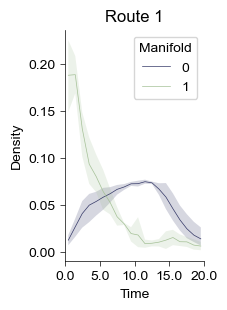

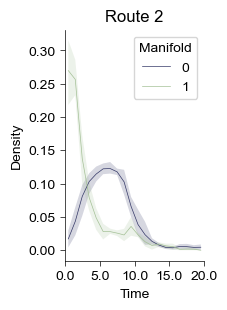

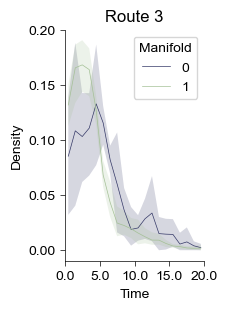

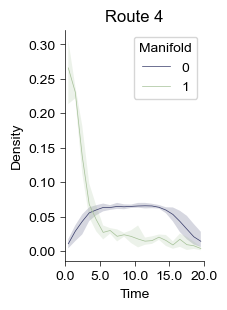

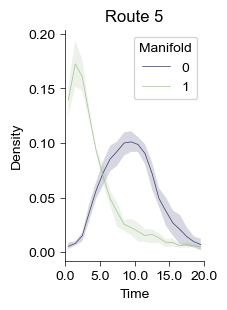

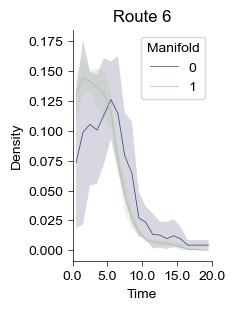

In [ ]:
if exists(join(figdata, f"{code_id} [Time & Manifold Identity].pkl")) == False:
    TMIData = {
        'MiceID': [],
        'Time': [],
        'Density': [],
        'Manifold': [],
        'Route': []
    }
    
    for mouse in [10212, 10224, 10227, 10232]:
        with open(join(loc, f"{mouse}.pkl"), 'rb') as handle:
            res = pickle.load(handle)
    
        time_traj = res['time_traj']/1000
        manifold_traj = res['manifold_traj']
        route_traj = res['route_traj']
        
        print(mouse)
        for r in range(1, 7):
            idx_m0 = np.where((manifold_traj == 0) & (route_traj == r))[0]
            idx_m1 = np.where((manifold_traj == 1) & (route_traj == r))[0]
            print(f"{len(idx_m0)}, {len(idx_m1)}")
            print(f"    KSTest: {ks_2samp(time_traj[idx_m0], time_traj[idx_m1])}")
            
            time_m0 = np.histogram(
                time_traj[idx_m0],
                bins = 20,
                range = (0, 20),
                density=True
            )[0]
            
            time_m1 = np.histogram(
                time_traj[idx_m1],
                bins = 20,
                range = (0, 20),
                density=True
            )[0]
            
            TMIData['MiceID'].append(np.repeat(mouse, 40))
            TMIData['Time'].append(np.concatenate([np.arange(20), np.arange(20)]))
            TMIData['Density'].append(np.concatenate([time_m0, time_m1]))
            TMIData['Manifold'].append(np.concatenate([np.repeat(0, 20), np.repeat(1, 20)]))
            TMIData['Route'].append(np.repeat(r, 40))
        print()
            
    for k in TMIData.keys():
        TMIData[k] = np.concatenate(TMIData[k])
    
    with open(join(figdata, f"{code_id} [Time & Manifold Identity].pkl"), 'wb') as handle:
        pickle.dump(TMIData, handle)
        
    TMID = pd.DataFrame(TMIData)
    TMID.to_excel(join(figdata, f"{code_id} [Time & Manifold Identity].xlsx"), index=False)
    print(len(TMID))
else:
    with open(join(figdata, f"{code_id} [Time & Manifold Identity].pkl"), 'rb') as handle:
        TMIData = pickle.load(handle)
        
for r in range(1, 7):
    SubTMIData = SubDict(TMIData, TMIData.keys(), np.where(TMIData['Route'] == r)[0])
    fig = plt.figure(figsize=(1.8, 3))
    ax = Clear_Axes(plt.axes(), close_spines=['top', 'right'], ifxticks=True, ifyticks=True)
    sns.lineplot(
        x='Time',
        y='Density',
        data=SubTMIData,
        hue='Manifold',
        palette=RemappingPalette,
        linewidth=0.5,
        err_kws={'edgecolor': None},
        ax=ax
    )
    ax.set_title(f"Route {r}")
    ax.set_xlim(-0.5, 19.5)
    ax.set_xticks(np.linspace(-0.5, 19.5, 5), np.linspace(0, 20, 5))
    plt.savefig(os.path.join(loc, f"Time Distribution [Route {r}].png"), dpi = 600)
    plt.savefig(os.path.join(loc, f"Time Distribution [Route {r}].svg"), dpi = 600)
    plt.close()
    

10212
5615, 1393
    KSTest: KstestResult(statistic=0.47280621399837247, pvalue=2.319981009493625e-227, statistic_location=149.1492663965103, statistic_sign=-1)
3031, 675
    KSTest: KstestResult(statistic=0.6653973141732957, pvalue=1.2485887320260973e-235, statistic_location=60.94013137421372, statistic_sign=-1)
482, 2317
    KSTest: KstestResult(statistic=0.06258719155009787, pvalue=0.0836005771798695, statistic_location=22.761215277461147, statistic_sign=-1)
5359, 733
    KSTest: KstestResult(statistic=0.607968591806773, pvalue=2.613525670109615e-226, statistic_location=45.153083181198795, statistic_sign=-1)
3912, 3022
    KSTest: KstestResult(statistic=0.6738160104699146, pvalue=0.0, statistic_location=121.63381348345634, statistic_sign=-1)
1408, 1277
    KSTest: KstestResult(statistic=0.2013502660710472, pvalue=3.0831182538778837e-24, statistic_location=81.17373286559621, statistic_sign=-1)

10224
8493, 1849
    KSTest: KstestResult(statistic=0.5850114085617673, pvalue=4.293e-321,

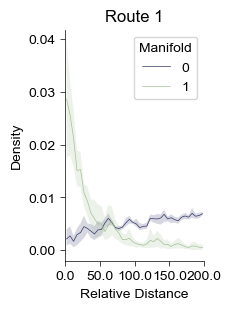

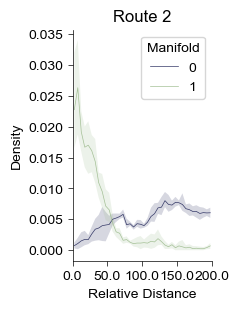

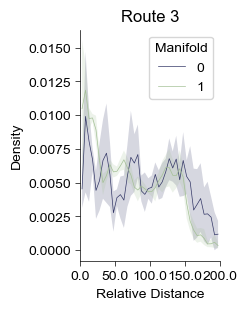

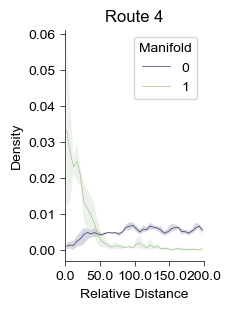

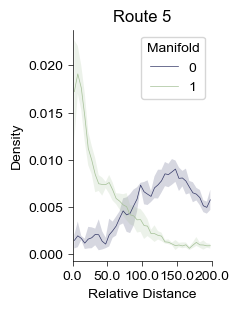

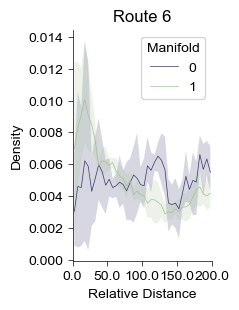

In [ ]:
if exists(join(figdata, f"{code_id}  [EgoPos & Manifold Identity].pkl")) == False:
    EPMIData = {
        'MiceID': [],
        'Relative Distance': [],
        'Density': [],
        'Manifold': [],
        'Route': []
    }
    
    for mouse in [10212, 10224, 10227, 10232]:
        with open(join(loc, f"{mouse}.pkl"), 'rb') as handle:
            res = pickle.load(handle)
    
        len_traj = res['len_traj']
        manifold_traj = res['manifold_traj']
        route_traj = res['route_traj']
        
        print(mouse)
        for r in range(1, 7):
            idx_m0 = np.where((manifold_traj == 0) & (route_traj == r))[0]
            idx_m1 = np.where((manifold_traj == 1) & (route_traj == r))[0]
            print(f"{len(idx_m0)}, {len(idx_m1)}")
            print(f"    KSTest: {ks_2samp(len_traj[idx_m0], len_traj[idx_m1])}")
            
            ego_m0 = np.histogram(
                len_traj[idx_m0],
                bins = 40,
                range = (0, 200),
                density=True
            )[0]
            
            ego_m1 = np.histogram(
                len_traj[idx_m1],
                bins = 40,
                range = (0, 200),
                density=True
            )[0]
            
            EPMIData['MiceID'].append(np.repeat(mouse, 80))
            EPMIData['Relative Distance'].append(np.concatenate([np.arange(40), np.arange(40)]))
            EPMIData['Density'].append(np.concatenate([ego_m0, ego_m1]))
            EPMIData['Manifold'].append(np.concatenate([np.repeat(0, 40), np.repeat(1, 40)]))
            EPMIData['Route'].append(np.repeat(r, 80))
        print()
            
    for k in EPMIData.keys():
        EPMIData[k] = np.concatenate(EPMIData[k])
    
    with open(join(figdata, f"{code_id} [EgoPos & Manifold Identity].pkl"), 'wb') as handle:
        pickle.dump(EPMIData, handle)
        
    EPMID = pd.DataFrame(EPMIData)
    EPMID.to_excel(join(figdata, f"{code_id} [EgoPos & Manifold Identity].xlsx"), index=False)
    print(len(EPMID))
else:
    with open(join(figdata, f"{code_id} [EgoPos & Manifold Identity].pkl"), 'rb') as handle:
        EPMIData = pickle.load(handle)
        
for r in range(1, 7):
    SubEPMIData = SubDict(EPMIData, EPMIData.keys(), np.where(EPMIData['Route'] == r)[0])
    fig = plt.figure(figsize=(1.8, 3))
    ax = Clear_Axes(plt.axes(), close_spines=['top', 'right'], ifxticks=True, ifyticks=True)
    sns.lineplot(
        x='Relative Distance',
        y='Density',
        data=SubEPMIData,
        hue='Manifold',
        palette=RemappingPalette,
        linewidth=0.5,
        err_kws={'edgecolor': None},
        ax=ax
    )
    ax.set_title(f"Route {r}")
    ax.set_xlim(-0.5, 39.5)
    ax.set_xticks(np.linspace(-0.5, 39.5, 5), np.linspace(0, 200, 5))
    plt.savefig(os.path.join(loc, f"Relative Distance Distribution [Route {r}].png"), dpi = 600)
    plt.savefig(os.path.join(loc, f"Relative Distance Distribution [Route {r}].svg"), dpi = 600)
    plt.close()
    

# Dynamics with Speed

In [ ]:
import scipy.stats


def derivate(vectors, n: int = 1):
    return np.diff(vectors, n=n, axis=0)

def process(mouse):
    with open(join(loc, f"{mouse}.pkl"), 'rb') as handle:
        res = pickle.load(handle)
    
    reduced_traj = res['reduced_traj']
    lap_traj = res['lap_traj']
    manifold_traj = res['manifold_traj']
    m1_centroid = res['m1_centroid']
    retriv_state_traj = np.where(res['retriv_state_traj'] == 1, 1, 0)
    
    beg = np.concatenate([[0], np.where(np.ediff1d(lap_traj) != 0)[0]+1])
    end = np.concatenate([np.where(np.ediff1d(lap_traj) != 0)[0]+1, [reduced_traj.shape[0]]])
    
    """
    for i in range(len(beg)):
        reduced_traj[beg[i]:end[i], 0] = np.convolve(reduced_traj[beg[i]:end[i], 0], np.ones(5)/5, 'same')
        reduced_traj[beg[i]:end[i], 1] = np.convolve(reduced_traj[beg[i]:end[i], 1], np.ones(5)/5, 'same')
        reduced_traj[beg[i]:end[i], 2] = np.convolve(reduced_traj[beg[i]:end[i], 2], np.ones(5)/5, 'same')
    """   
    
    m1_idx = np.where(manifold_traj == 1)[0]
    cent = np.mean(reduced_traj[m1_idx, :], axis=0)
    
    res_traj = np.linalg.norm(reduced_traj - cent[np.newaxis, :], axis=1)
    
    # Norm of vectors
    norm_traj = np.linalg.norm(reduced_traj - cent[np.newaxis, :], axis=1)
    for i in range(len(beg)):
        fig = plt.figure(figsize=(4, 2))
        ax = Clear_Axes(plt.axes(), close_spines=['top', 'right'], ifxticks=True, ifyticks=True)
        ax.scatter(
            np.arange(beg[i], end[i]),
            res_traj[beg[i]:end[i]],
            c=MAPPaletteRGBA[retriv_state_traj[beg[i]:end[i]], :],
            s=3,
            edgecolor=None
        )
        ax.set_ylim(0, 8)
        plt.show()
    
    

# Topology Data Analysis

        E:\Data\FinalResults\Dsp\Reforming Neural Trajectory Analysis\tda is already existed!


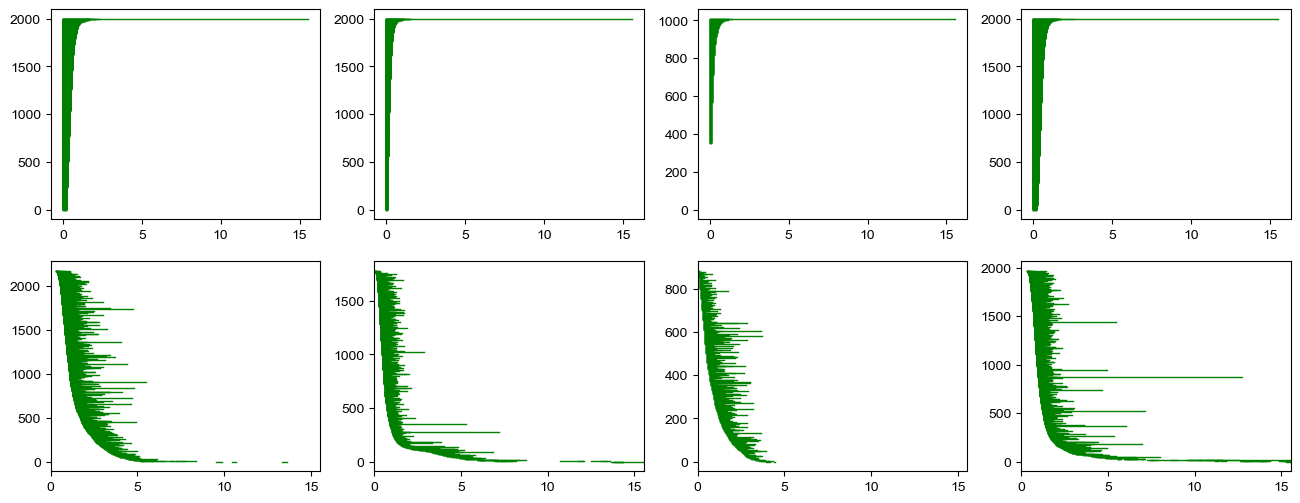

In [9]:
file_name = join(loc, 'tda')
mkdir(file_name)
from ripser import ripser

def convert_dgms_to_lifespans(obj: dict):
    dgms = obj['dgms']
    lifespans = []
    max_dim = 1
    for dim in range(max_dim + 1):
        length = []
        for idx, (birth, death) in enumerate(dgms[dim]):
            length.append(death - birth)
        lifespans.append(np.array(length, dtype=np.float64))
    return lifespans

def analyze_topology(mouse, session):
    with open(join(file_name, f"{mouse}_S{session+1}.pkl"), 'rb') as handle:
        res = pickle.load(handle)
    
    for crossval in range(1):
        fig, axes = plt.subplots(nrows=2, ncols=4, figsize=(16, 6))
        max_radius = 0
    
        rigs = np.vstack([
            res[0][crossval]['dgms'][0], 
            res[0][crossval]['dgms'][1],
            res[1][crossval]['dgms'][0],
            res[1][crossval]['dgms'][1],
            res[2][crossval]['dgms'][0],
            res[2][crossval]['dgms'][1]
        ])[:, 1]
    
        max_radius = np.max(rigs[np.isinf(rigs) == False])
    
        for c in range(4):
            dgms_obj = res[c][crossval]['dgms']
                
            for r in range(2):
                ax = axes[r, c]
                dgms_obj[r][np.where(np.isinf(dgms_obj[r]))] = max_radius
            
                for l in range(dgms_obj[r].shape[0]):
                    ax.plot(
                        dgms_obj[r][l, :],
                        np.repeat(l, 2),
                        lw=1,
                        c='green'
                    )
                
            ax.set_xlim(0, max_radius)
        plt.show()
    
analyze_topology(10232, 5)